# WGAN-GP

In [1]:
import torch
from torch import nn, optim, autograd
import torch.nn.functional as F
import time
import os
import datetime
import glob
import csv

import torchvision
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset, random_split
from torchvision import transforms
from torchvision.datasets import DatasetFolder

import pandas as pd
import seaborn as sns

from numpy import genfromtxt

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Hyper-parameters

In [2]:
latent_dim = 128
dim = 32
img_size = 3680
num_epochs = 50
batch_size = 32
num_workers = 4

PATH = './data/train'
IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')
DATA_EXTENSIONS = ('.csv','.txt')

### Check GPU

In [3]:
use_gpu = torch.cuda.is_available()
#device_ids = [0,1,2,3,4,5,6]

if use_gpu:
    #net = nn.DataParallel(net, device_ids=device_ids)
    device = torch.device('cuda:3')
    print ('USE GPU')
else:
    device = torch.device('cpu')
    print ('USE CPU')

USE GPU


### Define Functions

In [4]:
def plotSpec(seyfert,n):
    if seyfert == 1.9:
        plt.plot(np.linspace(3800,7500,7500-3800+1), sy19_feature[n].tolist())
    if seyfert == 2:
        plt.plot(np.linspace(3800,7500,7500-3800+1), sy2_feature[n].tolist())
        
def plotCurve(grid):
    grid = grid.cpu().detach().numpy()
    grid[grid == 0] = None
    plt.figure(figsize=(12,4))
    plt.plot(np.linspace(3800,7479,3680),grid,'.-',linewidth=0.5,markersize=2)
    plt.xlabel('Wavelength (A)')
    plt.ylabel('Flux')
        
def sizeMap(inputSize):
    C1 = (inputSize-50)+1
    S2 = int(C1/2)
    C3 = (S2-50)+1
    S4 = int(C3/2)
    return C1, S2, C3, S4


def read_data(filename, delimiter=','):
    with open(filename, 'r') as my_file:
        reader = csv.reader(my_file, delimiter=delimiter)
        my_list = list(reader)[0]
        my_list= [float(i) for i in my_list]
        return my_list

def load_dataset():
    train_dataset = DatasetFolder(
        loader = read_data,
        extensions = DATA_EXTENSIONS,
        root=PATH,
        #transform=transforms.ToTensor()
    )
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=True
    )
    return train_loader

## read data

In [5]:
# The feature size is 1x(7500-3800+1), a pixel to one wavelenght
# merge data in previouly defined in different files
sy19_feature_1 = read_data('sy19-pixels-3800-7500-redshifted-normalized.csv', delimiter=',')
sy19_feature_2 = read_data('sy19-test-pixels-3800-7500-redshifted-normalized.csv', delimiter=',')
sy20_feature_1 = read_data('sy20-pixels-3800-7500-redshifted-normalized.csv', delimiter=',')
sy20_feature_2 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.0.csv', delimiter=',')
sy20_feature_3 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.1.csv', delimiter=',')
sy20_feature_4 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.2.csv', delimiter=',')
sy20_feature_5 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.3.csv', delimiter=',')
sy20_feature_6 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.4.csv', delimiter=',')
sy20_feature_7 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.5.csv', delimiter=',')
sy20_feature_8 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.6.csv', delimiter=',')

In [6]:
##  Small sample pre-traning
#sy19_feature = sy19_feature_1
#sy20_feature = sy20_feature_1

## Full sample
sy19_feature = np.concatenate((sy19_feature_1, sy19_feature_2), axis=0)
sy20_feature = np.concatenate((sy20_feature_1, sy20_feature_2,sy20_feature_3,sy20_feature_4,\
                               sy20_feature_5,sy20_feature_6,sy20_feature_7,sy20_feature_8), axis=0)

sy19_feature = torch.Tensor(sy19_feature).view(-1,7500-3800+1)[:,:3680]
sy20_feature = torch.Tensor(sy20_feature).view(-1,7500-3800+1)[:,:3680]

In [7]:
sy19_feature.size()

torch.Size([745, 3680])

In [8]:
print(len(sy19_feature),len(sy20_feature))

745 8400


In [9]:
# classify 1.9 as 1, and 2 as 0. 
sy19_label = torch.ones(sy19_feature.size(0),dtype=torch.long)
sy20_label = torch.zeros(sy20_feature.size(0),dtype=torch.long)

sy19_dataset = TensorDataset(sy19_feature,sy19_label)
sy20_dataset = TensorDataset(sy20_feature,sy20_label)

In [10]:
sy19_dataloader = DataLoader(sy19_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
sy20_dataloader = DataLoader(sy20_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [11]:
# release memory

del  sy20_feature_1, sy20_feature_2,sy20_feature_3,sy20_feature_4,
sy20_feature_5,sy20_feature_6,sy20_feature_7,sy20_feature_8

del sy19_dataset, sy20_dataset

### Networks

In [5]:
class WGANGP():
    def __init__(self, generator, discriminator, g_optmizer, d_optimizer, img_size,
                 latent_dim, dataset_name, n_critic=10, gamma=10,
                 save_every=20, use_gpu=True, logdir=None):

        self.G = generator
        self.D = discriminator
        self.G_opt = g_optmizer
        self.D_opt = d_optimizer
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.dataset_name = dataset_name
        self.n_critic = n_critic
        self.gamma = gamma
        self.save_every = save_every
        self.use_gpu = use_gpu
        #self.writer = SummaryWriter(logdir)
        self.steps = 0
        self._fixed_z = torch.randn(64)
        self.hist = []
        self.images = []

        if self.use_gpu:
            self._fixed_z = self._fixed_z.to(device)
            self.G.to(device)
            self.D.to(device)

    def train(self, data_loader, n_epochs):
        #self._save_gif()
        for epoch in range(1, n_epochs + 1):
            print('Starting epoch {}...'.format(epoch))
            g_loss, d_loss, grad_penalty = self._train_epoch(data_loader)

            if epoch % self.save_every == 0 or epoch == n_epochs:
            #    torch.save(self.G.state_dict(), self.dataset_name + '_gen_{}.pt'.format(epoch))
            #    torch.save(self.D.state_dict(), self.dataset_name + '_disc_{}.pt'.format(epoch))
                print('epoch {}...'.format(epoch))
                print('    g_loss: {:.3f} d_loss: {:.3f} grad_penalty: {:.3f}'.format(g_loss, d_loss, grad_penalty))

    def _train_epoch(self, data_loader):
        for i, (data, _) in enumerate(data_loader):
            self.steps += 1
            data = data.view(-1,1,self.img_size)
            if self.use_gpu:
                data = data.to(device)

            d_loss, grad_penalty = self._discriminator_train_step(data)
            #self.writer.add_scalars('losses', {'d_loss': d_loss, 'grad_penalty': grad_penalty}, self.steps)
            self.hist.append({'d_loss': d_loss, 'grad_penalty': grad_penalty})

            #if i % 200 == 0:
            #    img_grid = make_grid(self.G(self._fixed_z).cpu().data, normalize=True)
            #    self.writer.add_image('images', img_grid, self.steps)

            if self.steps % self.n_critic == 0:
                g_loss = self._generator_train_step(data.size(0))
                #self.writer.add_scalars('losses', {'g_loss': g_loss}, self.steps)
                self.hist[-1]['g_loss'] = g_loss
        

        print('    g_loss: {:.3f} d_loss: {:.3f} grad_penalty: {:.3f}'.format(g_loss, d_loss, grad_penalty))
        return g_loss, d_loss, grad_penalty

    def _discriminator_train_step(self, data):
        batch_size = data.size(0)
        generated_data = self._sample(batch_size)
        grad_penalty = self._gradient_penalty(data, generated_data)
        d_loss = self.D(generated_data).mean() - self.D(data).mean() + grad_penalty
        self.D_opt.zero_grad()
        d_loss.backward()
        self.D_opt.step()
        return d_loss.item(), grad_penalty.item()

    def _generator_train_step(self, batch_size):
        generated_data = self._sample(batch_size)
        g_loss = -self.D(generated_data).mean()
        self.G_opt.zero_grad()
        g_loss.backward()
        self.G_opt.step()
        return g_loss.item()

    def _gradient_penalty(self, data, generated_data, gamma=10):
        batch_size = data.size(0)
        epsilon = torch.rand(batch_size, 1, 1)
        epsilon = epsilon.expand_as(data)

        if self.use_gpu:
            epsilon = epsilon.to(device)

        interpolation = epsilon * data + (1 - epsilon) * generated_data

        if self.use_gpu:
            interpolation = interpolation.to(device)

        interpolation_logits = self.D(interpolation)
        grad_outputs = torch.ones(interpolation_logits.size())

        if self.use_gpu:
            grad_outputs = grad_outputs.to(device)

        gradients = autograd.grad(outputs=interpolation_logits,
                                  inputs=interpolation,
                                  grad_outputs=grad_outputs,
                                  create_graph=True,
                                  retain_graph=True)[0]

        gradients = gradients.view(batch_size, -1)
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)
        return self.gamma * ((gradients_norm - 1) ** 2).mean()

    def _sample(self, n_samples):
        z = torch.randn(n_samples, self.latent_dim)
        if self.use_gpu:
            z = z.to(device)
        return self.G(z)

    def _save_gif(self):
        grid = make_grid(self.G(self._fixed_z).cpu().data, normalize=True)
        grid = np.transpose(grid.numpy(), (1, 2, 0))
        self.images.append(grid)
        imageio.mimsave('{}.gif'.format(self.dataset_name), self.images)


In [6]:
## latent -> feature -> image
## input: latent (batch_size, latent_dim)
## output: image (batch_size, img_size)
class Generator(nn.Module):
    def __init__(self, latent_dim, image_size, d=32):
        super(Generator, self).__init__()
        
        self.d = d
        self.latent_dim = latent_dim
        self.img_size = img_size
        self.feature_sizes = self.img_size // 16 # 4 convolutions of stride 2

        self.latent_to_features = nn.Sequential(
            # 4 convolutions of stride 2 -> output size will be 8 * feature_sizes
            nn.Linear(self.latent_dim,  self.d * 8 * self.feature_sizes),
            nn.ReLU()
        )
        
        self.features_to_image = nn.Sequential(

            nn.ConvTranspose1d(self.d * 8, self.d * 4, 4, 2, 1),
            nn.BatchNorm1d(self.d * 4),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose1d(self.d * 4, self.d * 2, 4, 2, 1),
            nn.BatchNorm1d(self.d * 2),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose1d(self.d * 2, self.d, 4, 2, 1),
            nn.BatchNorm1d(self.d),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose1d(self.d, 1, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.latent_to_features(x)
        x = x.view(-1, 8 * self.d, self.feature_sizes)
        return self.features_to_image(x)

## image to feature to scale
## input: image (batch_size, img_size)
## out: scale (batch_size, 1)
class Discriminator(nn.Module):
    def __init__(self, img_size, d=32):
        super(Discriminator, self).__init__()
        
        self.d = d
        self.img_size = img_size
        # 4 convolutions of stride 2 -> output size will be 8 * (img_size / 2^4)
        self.output_size = self.d * 8 * self.img_size // 16
        
        self.image_to_features = nn.Sequential(
            nn.Conv1d(1, self.d, 4, 2, 1),
            nn.InstanceNorm1d(self.d),
            nn.LeakyReLU(0.2),

            nn.Conv1d(self.d, self.d * 2, 4, 2, 1),
            nn.InstanceNorm1d(self.d * 2),
            nn.LeakyReLU(0.2),

            nn.Conv1d(self.d * 2, self.d * 4, 4, 2, 1),
            nn.InstanceNorm1d(self.d * 4),
            nn.LeakyReLU(0.2),

            nn.Conv1d(self.d * 4, self.d * 8, 4, 2, 1),
        )
        
        self.features_to_scale = nn.Sequential(
            nn.Linear(self.output_size, 1)
        )
        
    def forward(self, x):
        batch_size = x.size(0)
        #x = x.view(batch_size,1,-1)
        x = self.image_to_features(x)
        x = x.view(batch_size, -1)
        return self.features_to_scale(x)

## Main 

In [7]:
data_loader = sy19_dataloader

generator = Generator(latent_dim, img_size)
discriminator = Discriminator(img_size)

g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.9))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.9))


#learning_rate = 0.0001
#g_optimizer = optim.SGD(generator.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.001)
#d_optimizer = optim.SGD(discriminator.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.001)


wgan = WGANGP(generator, discriminator, g_optimizer, d_optimizer, img_size, latent_dim, 'XRT')

In [131]:
wgan.train(data_loader, 100)

Starting epoch 1...
    g_loss: 0.237 d_loss: -0.295 grad_penalty: 0.031
Starting epoch 2...
    g_loss: 0.281 d_loss: -0.410 grad_penalty: 0.033
Starting epoch 3...
    g_loss: 0.332 d_loss: -0.761 grad_penalty: 0.171
Starting epoch 4...
    g_loss: 0.553 d_loss: -0.531 grad_penalty: 0.015
Starting epoch 5...
    g_loss: 0.177 d_loss: -0.547 grad_penalty: 0.024
Starting epoch 6...
    g_loss: 0.093 d_loss: -0.456 grad_penalty: 0.018
Starting epoch 7...
    g_loss: 0.402 d_loss: -0.670 grad_penalty: 0.037
Starting epoch 8...
    g_loss: 0.579 d_loss: -0.491 grad_penalty: 0.039
Starting epoch 9...
    g_loss: 0.642 d_loss: -0.136 grad_penalty: 0.019
Starting epoch 10...
    g_loss: 0.714 d_loss: -0.205 grad_penalty: 0.018
Starting epoch 11...
    g_loss: 0.443 d_loss: -0.738 grad_penalty: 0.020
Starting epoch 12...
    g_loss: 0.373 d_loss: -0.489 grad_penalty: 0.049
Starting epoch 13...
    g_loss: 0.601 d_loss: -0.535 grad_penalty: 0.162
Starting epoch 14...
    g_loss: 0.226 d_loss: 

### Result

In [1]:
z = torch.randn(latent_dim).to(device)
plotCurve(wgan.G(z).squeeze())

NameError: name 'torch' is not defined

## save model

In [65]:
torch.save(wgan.G.state_dict(), 'WGAN-GP-Seyfert-1.9-gen.pt')
torch.save(wgan.D.state_dict(), 'WGAN-GP-Seyfert-1.9-disc.pt')

![caption](figure1_1.gif)

In [55]:
data_loader20 = sy20_dataloader

generator20 = Generator(latent_dim, img_size)
discriminator20 = Discriminator(img_size)

g_optimizer20 = torch.optim.Adam(generator20.parameters(), lr=1e-4, betas=(0.5, 0.9))
d_optimizer20 = torch.optim.Adam(discriminator20.parameters(), lr=1e-4, betas=(0.5, 0.9))


#learning_rate = 0.0001
#g_optimizer = optim.SGD(generator.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.001)
#d_optimizer = optim.SGD(discriminator.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.001)


wgan20 = WGANGP(generator20, discriminator20, g_optimizer20, d_optimizer20, img_size, latent_dim, 'XRT')

In [133]:
wgan20.train(data_loader20, 100)

Starting epoch 1...
    g_loss: 0.409 d_loss: -0.620 grad_penalty: 0.054
Starting epoch 2...
    g_loss: 0.834 d_loss: -0.389 grad_penalty: 0.072
Starting epoch 3...
    g_loss: 0.559 d_loss: -0.509 grad_penalty: 0.046
Starting epoch 4...
    g_loss: 0.743 d_loss: -0.406 grad_penalty: 0.081
Starting epoch 5...
    g_loss: 0.825 d_loss: -0.725 grad_penalty: 0.019
Starting epoch 6...
    g_loss: 0.727 d_loss: -0.853 grad_penalty: 0.064
Starting epoch 7...
    g_loss: 0.798 d_loss: -0.446 grad_penalty: 0.059
Starting epoch 8...
    g_loss: 0.531 d_loss: -0.578 grad_penalty: 0.020
Starting epoch 9...
    g_loss: 0.512 d_loss: -0.673 grad_penalty: 0.060
Starting epoch 10...
    g_loss: 0.759 d_loss: -0.615 grad_penalty: 0.061
Starting epoch 11...
    g_loss: 0.581 d_loss: -0.487 grad_penalty: 0.059
Starting epoch 12...
    g_loss: 0.480 d_loss: -0.863 grad_penalty: 0.054
Starting epoch 13...
    g_loss: 0.810 d_loss: -0.303 grad_penalty: 0.032
Starting epoch 14...
    g_loss: 0.701 d_loss: 

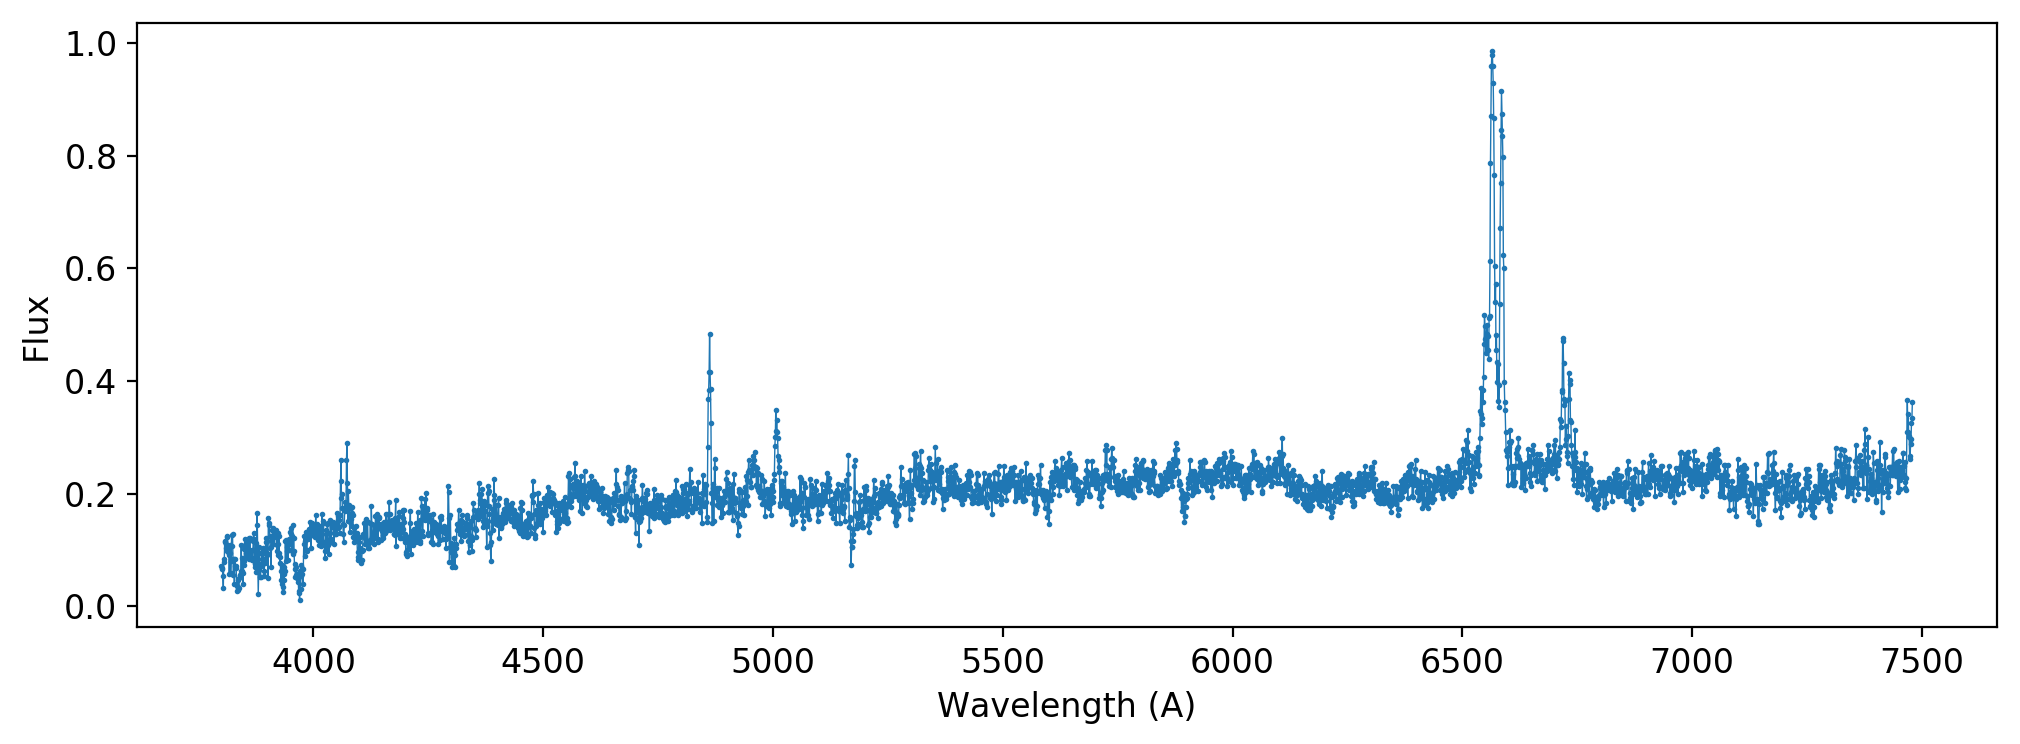

In [132]:
z = torch.randn(latent_dim).to(device)
plotCurve(wgan20.G(z).squeeze())

In [124]:
torch.save(wgan20.G.state_dict(), 'WGAN-GP-Seyfert-2.0-gen.pt')
torch.save(wgan20.D.state_dict(), 'WGAN-GP-Seyfert-2.0-disc.pt')

# Load saved network and generate data

In [8]:
generator = Generator(latent_dim, img_size)
discriminator = Discriminator(img_size)

g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.9))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.9))

wgan = WGANGP(generator, discriminator, g_optimizer, d_optimizer, img_size, latent_dim, 'XRT')

In [12]:
wgan.G.eval()
wgan.G.load_state_dict('./WGAN-GP-Seyfert-1.9-gen.pt')

AttributeError: 'str' object has no attribute 'copy'

In [13]:
wgan.G

Generator(
  (latent_to_features): Sequential(
    (0): Linear(in_features=128, out_features=58880, bias=True)
    (1): ReLU()
  )
  (features_to_image): Sequential(
    (0): ConvTranspose1d(256, 128, kernel_size=(4,), stride=(2,), padding=(1,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose1d(128, 64, kernel_size=(4,), stride=(2,), padding=(1,))
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose1d(64, 32, kernel_size=(4,), stride=(2,), padding=(1,))
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): ConvTranspose1d(32, 1, kernel_size=(4,), stride=(2,), padding=(1,))
    (10): Tanh()
  )
)